In [2]:
import math
import os
from six.moves import xrange
import numpy as np
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets

%matplotlib inline
import matplotlib.pyplot as plt

In [33]:
num_classes = 10

image_size = 28
image_pixels = image_size * image_size

batch_size = 100
eval_batch_size = 1
hidden_units_1 = 128
hidden_units_2 = 32

max_steps = 2000
train_dir = "/Users/trinakarmakar/anaconda2/train/"
test_dir = "/Users/trinakarmakar/anaconda2/test/"

In [8]:
data_sets = read_data_sets(train_dir, False)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /Users/trinakarmakar/anaconda2/train/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /Users/trinakarmakar/anaconda2/train/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /Users/trinakarmakar/anaconda2/train/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /Users/trinakarmakar/anaconda2/train/t10k-labels-idx1-ubyte.gz


In [25]:
def mnist_inference(images, hidden_unit_1, hidden_unit_2):
    with tf.name_scope('hidden_1'):
        weights = tf.Variable(
           tf.truncated_normal([image_pixels, hidden_unit_1], stddev=1.0 / math.sqrt(float(image_pixels))), 
           name = 'weights')
        biases = tf.Variable(tf.zeros([hidden_unit_1]), name='biases')
        hidden1 = tf.nn.relu(tf.matmul(images, weights) + biases)
    with tf.name_scope('hidden_2'):
        weights = tf.Variable(
           tf.truncated_normal([hidden_unit_1, hidden_unit_2], stddev=1.0 / math.sqrt(float(hidden_unit_1))), 
           name = 'weights')
        biases = tf.Variable(tf.zeros([hidden_unit_2]), name='biases')
        hidden2 = tf.nn.relu(tf.matmul(hidden1, weights) + biases)   
    with tf.name_scope('softmax_linear'):
        weights = tf.Variable(
           tf.truncated_normal([hidden_unit_2, num_classes], stddev=1.0 / math.sqrt(float(hidden_unit_2))), 
           name = 'weights')
        biases = tf.Variable(tf.zeros([num_classes]), name='biases')
        logits = tf.matmul(hidden2, weights) + biases
    return logits

In [28]:
#Build training graph
def mnist_training(logits, labels, learning_rate):
    labels = tf.to_int64(labels)
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits, labels, name='xentropy')
    loss = tf.reduce_mean(cross_entropy, name='xentropy_mean')
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    global_step = tf.Variable(0, name='global_step', trainable=False)
    train_op = optimizer.minimize(loss, global_step=global_step)
    return train_op, loss

In [29]:
#Build the complete model
mnist_graph = tf.Graph()
with mnist_graph.as_default():
    #Generate placeholder for images and labels
    images_placeholder = tf.placeholder(tf.float32)
    labels_placeholder = tf.placeholder(tf.float32)
    tf.add_to_collection("images", images_placeholder)
    tf.add_to_collection("labels", labels_placeholder)
    #Build graph that computes predictions from the inference model
    logits = mnist_inference(images_placeholder, hidden_units_1, hidden_units_2)
    tf.add_to_collection("logits", logits)
    
    #add to the graph the ops that calculate and apply gradients
    train_op, loss = mnist_training(logits, labels_placeholder, 0.01)
    #add the variable initializer op
    init = tf.initialize_all_variables()
    saver = tf.train.Saver()  #create a saver for training checkpoints
    #so what have we constructed
    #tf.train.write_graph(tf.get_default_graph().as_graph_def(). "/tmp", "complete.pbtxt", as_text=True)

Step 0: loss = 2.33
Step 1000: loss = 0.47


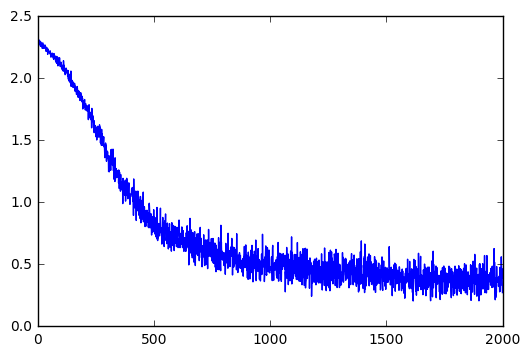

In [38]:
#run training for max_steps and save checkpoint at the end
with tf.Session(graph=mnist_graph) as sess:
    sess.run(init)
    losses = []
    for step in xrange(max_steps):
        images_feed, labels_feed = data_sets.train.next_batch(batch_size)
        _, loss_value = sess.run([train_op, loss], feed_dict={images_placeholder: images_feed,
                                                               labels_placeholder: labels_feed})
        
        if step % 1000 == 0:
            print('Step %d: loss = %.2f' % (step, loss_value))
        losses.append(loss_value)             
    #write a checkpoint
    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.plot(losses)
    plt.show()
    checkpoint_file = os.path.join(train_dir, 'checkpoint')
    saver.save(sess, checkpoint_file, global_step=step)

Ground truth: 4
Prediction: 4


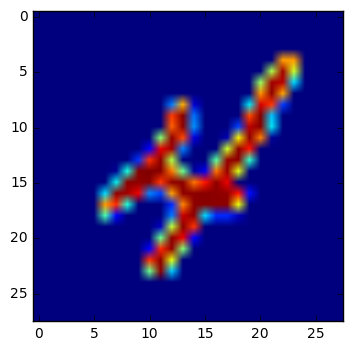

In [50]:
#run evaluation based on the saved checkpoint
with tf.Session(graph=tf.Graph()) as sess:
    saver = tf.train.import_meta_graph(
       os.path.join(train_dir, "checkpoint-1999.meta"))
    saver.restore(
       sess, os.path.join(train_dir, "checkpoint-1999"))
    
    #retrieves the op as we remember
    logits = tf.get_collection("logits")[0]
    images_placeholder = tf.get_collection("images")[0]
    labels_placeholder = tf.get_collection("labels")[0]
    
    #add an op that chooses the top-k predictions
    eval_op = tf.nn.top_k(logits)
    
    #run evaluation
    images_feed, labels_feed = data_sets.validation.next_batch(eval_batch_size)
    imgplot = plt.imshow(np.reshape(images_feed, (28, 28)))
    prediction = sess.run(eval_op, 
                          feed_dict={images_placeholder: images_feed,
                                    labels_placeholder: labels_feed})
    print("Ground truth: %d\nPrediction: %d" % (labels_feed, prediction.indices[0][0]))